# Traffic Sign Classifier Project

### Author: Patrick Barone
### Date: 3/10/2018

The purpose of this project is to design a traffic sign classifier, for use with German traffic signs, based roughly around the LeNet architecture.

In [1]:
import cv2
import csv
import pickle
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
from keras.preprocessing.image import random_rotation, random_shear, random_shift, random_zoom

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Load the training, validation and test datasets

training_file = 'train.p'
validation_file='valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
# Display summary information of the loaded datasets

n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_train.shape[1:3]
n_classes = np.unique(y_train).shape[0]
n_channels = X_train.shape[3]

print("Number of training examples =", n_train)
print("Number of validation examples = ", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print("Number of input channels =", n_channels)

Number of training examples = 34799
Number of validation examples =  4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43
Number of input channels = 3


In [4]:
# Load the class names from the signames.csv file into a list

names = []
with open('signnames.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        names.append(row[1])
names = names[1:]

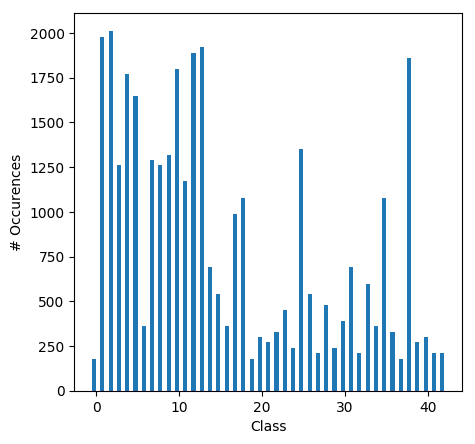

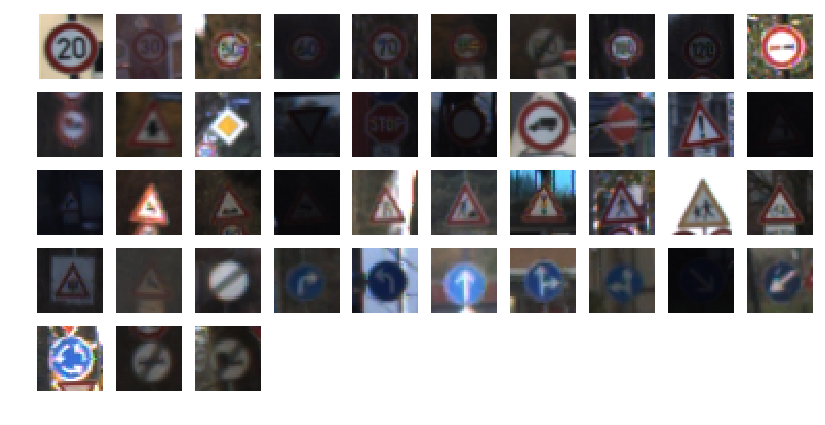

In [5]:
# Visualization of training data
# Create a distribution plot, comparing the number of examples in each dataset

# Count the number of unique entries in the y_train set

def plot_distribution(y_train, save_name=None):
    unique, counts = np.unique(y_train, return_counts=True)

    fig1, ax1 = plt.subplots(figsize=(5,5), dpi=100)
    ind = np.arange(len(unique))
    width = 0.5
    r1 = ax1.bar(ind-width/2, counts, width)
    ax1.set_xlabel('Class')
    ax1.set_ylabel('# Occurences')
    if save_name is not None:
        fig1.savefig(save_name)

plot_distribution(y_train, 'output_images/class_distribution.png')

# Display a grid of a sample of each type of image

def show_image_sample(X_train, y_train, save_name=None):
    w = 10
    h = 5
    fig2, ax2 = plt.subplots(figsize=(10,5), dpi=100)
    for idx in range(n_classes):
        image = X_train[y_train==idx][0]     
        plt.subplot(h,w,idx+1)
        if image.shape[2] == 1:
            plt.imshow(image.squeeze(),cmap="gray")
        else:
            plt.imshow(image)
        plt.axis('off')
        search_index = 0
    plt.show()
    if save_name is not None:
        fig2.savefig(save_name)
        
show_image_sample(X_train, y_train, 'output_images/class_samples.png')


8


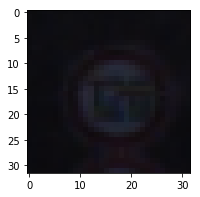

In [6]:
# Show a random image from the training set
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(3,3))
plt.imshow(image)
print(y_train[index])

Maximum number per class: 2010
Minimum number per class: 180


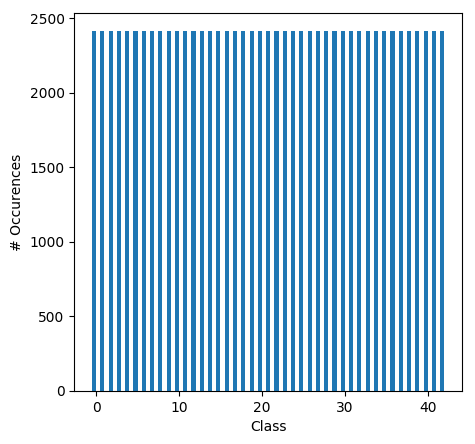

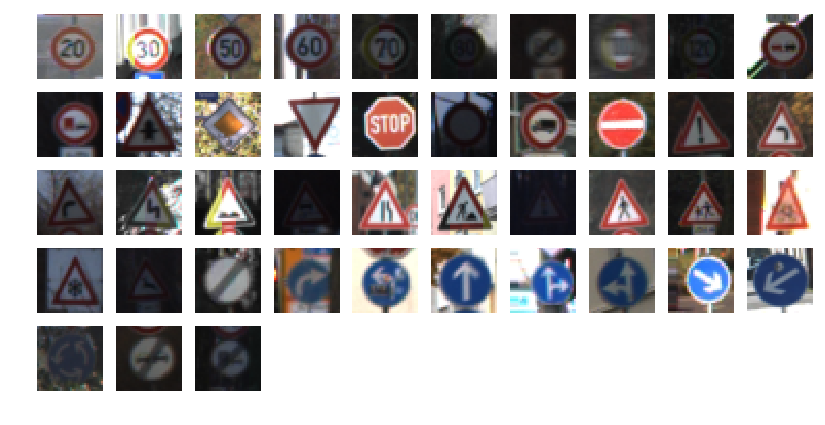

In [7]:
# We want to resample the dataset so that there is an equal number of images in each category
# I will use oversampling to achieve this ...
unique, counts = np.unique(y_train, return_counts=True)

max_n_images = np.max(counts)
min_n_images = np.min(counts)
print('Maximum number per class: %d' % max_n_images)
print('Minimum number per class: %d' % min_n_images)

max_n_images = int(max_n_images * 1.2)

for class_type in unique:
    idx = (y_train == class_type)
    images = X_train[idx]
    labels = y_train[idx]
    n_images = len(np.floor(images))
    
    samples_to_add = max_n_images - n_images
    rand_idx = np.random.choice(n_images, samples_to_add)
    images_to_add = images[rand_idx]
    
    # For all the images that we want to add, we should change each image slightly
    for idx in range(len(images_to_add)):
        transform_type = np.random.choice(4, 1)
        if transform_type == 0:
            images_to_add[idx] = random_zoom(images_to_add[idx], (0.9,1.1))
        elif transform_type == 1:
            images_to_add[idx] = random_shift(images_to_add[idx], 0.1, 0.1)
        elif transform_type == 2:
            images_to_add[idx] = random_shear(images_to_add[idx], 0.1)
        else:
            images_to_add[idx] = random_rotation(images_to_add[idx], 10)
    
    X_train = np.concatenate([X_train, images_to_add], axis=0)
    y_train = np.concatenate([y_train, class_type*np.ones(len(images_to_add))])
            
plot_distribution(y_train, 'output_images/class_distribution_resampled.png')   
show_image_sample(np.flip(X_train, axis=0), np.flip(y_train, axis=0))
   

In [8]:
# Preprocess the cells

'''
Convert a single image to grayscale
'''
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

'''
Perform histogram contrasts equalization on single image
'''
def hist_eq(img):
    return cv2.equalizeHist(img)

'''
Convert an entire tensor of images to grayscale
'''
def np_grayscale(img_arr):
    output = np.empty((img_arr.shape[0], img_arr.shape[1], img_arr.shape[2], 1), dtype=np.uint8)
    for idx in range(img_arr.shape[0]):
        output[idx, :, :, 0] = grayscale(img_arr[idx])
    return output

'''
Perform histogram equalization on an entire tensor of images
'''
def np_hist_eq(img_arr):
    output = np.empty((img_arr.shape[0], img_arr.shape[1], img_arr.shape[2], 1), dtype=np.uint8)
    for idx in range(img_arr.shape[0]):
        output[idx, :, :, 0] = hist_eq(img_arr[idx])
    return output

'''
Normalize grayscale images [0,255] to [-1.0, 1.0]
'''
def normalize(x):
    return (x-128.0)/128.0

'''
Run all preprocessing operations on tensor x
'''
def preprocess(x):
    y = np_grayscale(x)
    z = np_hist_eq(y)
    a = normalize(z)
    return a
     
# Normalize training, validation and test data
X_train_n = preprocess(X_train)
X_valid_n = preprocess(X_valid)
X_test_n = preprocess(X_test)

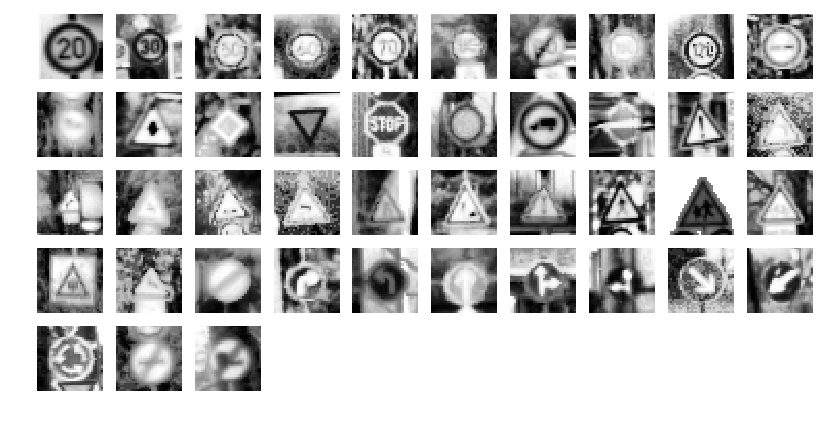

In [9]:
# Display a sampling of images after normalization
show_image_sample(X_train_n, y_train,'output_images/preprocessed_samples.png')

In [10]:
# Define Neural Network

# Variables && Placeholders
# x: input images
# y: output classifications
# keep_rate: probability of keeping a connection in dropout layer

x = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1], 1), name="input")
y = tf.placeholder(tf.int32, (None), name="output")
keep_rate = tf.placeholder(tf.float32, name='keep_rate')

# One hot encode numerical classification labels
one_hot_y = tf.one_hot(y, n_classes)

# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
mu = 0
sigma = 0.1

### Convolutional layers ###

# Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma), name="conv1_W")
conv1_b = tf.Variable(tf.zeros(6), name="conv1_b")
conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

# Activation.
conv1 = tf.nn.relu(conv1)

conv1 = tf.nn.dropout(conv1, keep_prob=keep_rate)

# Pooling. Input = 28x28x6. Output = 14x14x6.
conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

# Layer 2: Convolutional. Output = 10x10x16.
conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma), name="conv2_W")
conv2_b = tf.Variable(tf.zeros(16), name="conv2_b")
conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

# Activation.
conv2 = tf.nn.relu(conv2)

conv2 = tf.nn.dropout(conv2, keep_prob=keep_rate)

# Pooling. Input = 10x10x16. Output = 5x5x16.
conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

# Layer 3: Convolutional. Input 5x5x16, Output = 1x1x512
conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 512), mean = mu, stddev = sigma), name="conv3_W")
conv3_b = tf.Variable(tf.zeros(512), name="conv3_b")
conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b

# Activation.
conv3 = tf.nn.relu(conv3)

conv3 = tf.nn.dropout(conv3, keep_prob=keep_rate)

### Fully Connected Layers ###

# Flatten. Input = 5x5x16. Output = 400.
fc0   = flatten(conv3)

# Layer 3: Fully Connected. Input = 400. Output = 120.
fc1_W = tf.Variable(tf.truncated_normal(shape=(512, 120), mean = mu, stddev = sigma), name="fc1_W")
fc1_b = tf.Variable(tf.zeros(120), name="fc1_b")
fc1   = tf.matmul(fc0, fc1_W) + fc1_b

# Activation.
fc1    = tf.nn.relu(fc1)

# Dropout
fc1    = tf.nn.dropout(fc1, keep_prob=keep_rate)

# Layer 4: Fully Connected. Input = 120. Output = 84.
fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma), name="fc2_W")
fc2_b  = tf.Variable(tf.zeros(84), name="fc2_b")
fc2    = tf.matmul(fc1, fc2_W) + fc2_b

# Activation.
fc2    = tf.nn.relu(fc2)

# Dropout
fc2    = tf.nn.dropout(fc2, keep_prob=keep_rate)

# Layer 5: Fully Connected. Input = 84. Output = 43.
fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma), name="fc3_W")
fc3_b  = tf.Variable(tf.zeros(n_classes), name="fc3_b")
logits = tf.matmul(fc2, fc3_W) + fc3_b

In [11]:
EPOCHS = 25
BATCH_SIZE = 128

In [12]:
rate = 0.0004

# Seutp metrics and optimizer
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [13]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_rate: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [14]:
def accuracy_plot(training_accuracy, validataion_accuracy, save_name=None):
    fig1, ax1 = plt.subplots(figsize=(5,5), dpi=100);
    p1, = ax1.plot(np.arange(len(training_accuracy)), training_accuracy, c='b')
    p2, = ax1.plot(np.arange(len(validation_accuracy)), validation_accuracy, c='r')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend([p1, p2],['Training','Validation'])
    if save_name is not None:
        fig1.savefig(save_name)

Training...

EPOCH 1 ...
Training Accuracy = 0.477
Validation Accuracy = 0.415

EPOCH 2 ...
Training Accuracy = 0.705
Validation Accuracy = 0.620

EPOCH 3 ...
Training Accuracy = 0.800
Validation Accuracy = 0.714

EPOCH 4 ...
Training Accuracy = 0.838
Validation Accuracy = 0.743

EPOCH 5 ...
Training Accuracy = 0.862
Validation Accuracy = 0.785

EPOCH 6 ...
Training Accuracy = 0.891
Validation Accuracy = 0.827

EPOCH 7 ...
Training Accuracy = 0.909
Validation Accuracy = 0.846

EPOCH 8 ...
Training Accuracy = 0.916
Validation Accuracy = 0.852

EPOCH 9 ...
Training Accuracy = 0.926
Validation Accuracy = 0.866

EPOCH 10 ...
Training Accuracy = 0.937
Validation Accuracy = 0.883

EPOCH 11 ...
Training Accuracy = 0.948
Validation Accuracy = 0.897

EPOCH 12 ...
Training Accuracy = 0.957
Validation Accuracy = 0.907

EPOCH 13 ...
Training Accuracy = 0.961
Validation Accuracy = 0.916

EPOCH 14 ...
Training Accuracy = 0.962
Validation Accuracy = 0.916

EPOCH 15 ...
Training Accuracy = 0.966
Valid

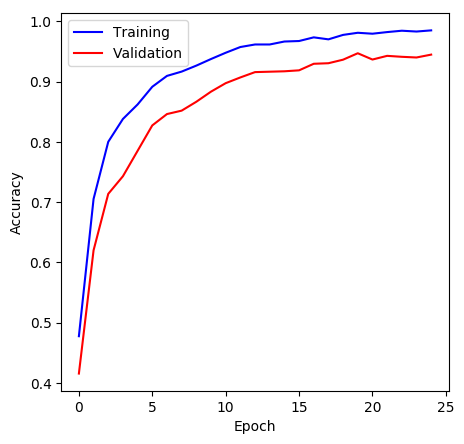

In [15]:
training_accuracy = []
validation_accuracy = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_n)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_n, y_train = shuffle(X_train_n, y_train)
            
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_n[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_rate: 0.5})
            
        t_accuracy = evaluate(X_train_n, y_train)
        v_accuracy = evaluate(X_valid_n, y_valid)
        training_accuracy.append(t_accuracy)
        validation_accuracy.append(v_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(t_accuracy))
        print("Validation Accuracy = {:.3f}".format(v_accuracy))
        print()
     
    accuracy_plot(training_accuracy, validation_accuracy,'output_images/training_accuracy.png')
    saver.save(sess, './signs')
    print("Model saved")

In [16]:
import cv2
img_names = ['1.jpg','2.jpg','3.jpg','4.jpg', '5.jpg']

X_new = np.array([np.array(cv2.cvtColor(cv2.imread('new_images/' + fname), cv2.COLOR_RGB2BGR)) for fname in img_names])
X_new = preprocess(X_new)


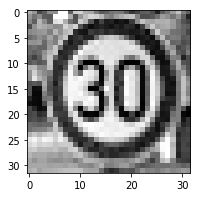

Class[1]: Speed limit (30km/h) (0.954634)
Class[2]: Speed limit (50km/h) (0.035700)
Class[0]: Speed limit (20km/h) (0.008747)
Class[7]: Speed limit (100km/h) (0.000464)
Class[4]: Speed limit (70km/h) (0.000261)


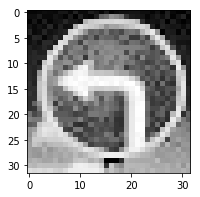

Class[34]: Turn left ahead (0.990159)
Class[35]: Ahead only (0.004857)
Class[38]: Keep right (0.003554)
Class[3]: Speed limit (60km/h) (0.000948)
Class[30]: Beware of ice/snow (0.000106)


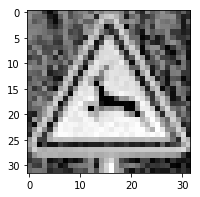

Class[23]: Slippery road (0.641859)
Class[19]: Dangerous curve to the left (0.119892)
Class[31]: Wild animals crossing (0.119260)
Class[21]: Double curve (0.100218)
Class[11]: Right-of-way at the next intersection (0.014946)


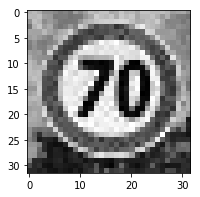

Class[1]: Speed limit (30km/h) (0.260079)
Class[8]: Speed limit (120km/h) (0.153737)
Class[4]: Speed limit (70km/h) (0.124491)
Class[2]: Speed limit (50km/h) (0.124377)
Class[7]: Speed limit (100km/h) (0.111548)


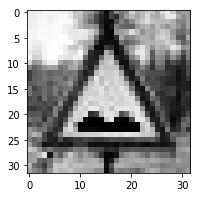

Class[22]: Bumpy road (0.999979)
Class[26]: Traffic signals (0.000019)
Class[25]: Road work (0.000001)
Class[18]: General caution (0.000000)
Class[31]: Wild animals crossing (0.000000)


In [17]:
import tensorflow as tf
import csv
output = tf.nn.softmax(logits)

out = []
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('./signs.meta')
    new_saver.restore(sess,tf.train.latest_checkpoint('./'))
    out = sess.run(output,feed_dict={x: X_new, keep_rate: 1.0})
            
for i in range(len(X_new)):
    plt.figure(figsize=(3,3))
    img = np.uint8(128.0*X_new[i]+128.0)
    plt.imshow(img[:,:,0], cmap="gray")
    plt.show()
    
    k = np.stack([np.arange(n_classes),out[i]]).transpose()
    k = np.flip(k[k[:,1].argsort()],0)
    k = k[0:5,:]
    for j in range(5):
        idx = np.int32(k[j,0])
        print("Class[%d]: %s (%.6f)" % (idx,names[idx],k[j,1]))
    

In [18]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('./signs.meta')
    new_saver.restore(sess,tf.train.latest_checkpoint('./'))
    out = sess.run(output,feed_dict={x: X_test_n, keep_rate: 1.0})
    test_accuracy = evaluate(X_test_n, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.918
